In [1]:
import numpy as np

from qiskit.quantum_info import Clifford, Pauli
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.random import random_clifford_circuit

from ldpc.mod2 import inverse, kernel, rank, reduced_row_echelon

from stim import PauliString, TableauSimulator, Circuit

In [2]:
def vec_to_pauli_str(x):
    #converts vector into Pauli string
        dic = {(0,0):'I', (0,1):'Z', (1,0):'X', (1,1):'Y'}
        n = len(x)//2
        return ''.join(dic[(x[i], x[n+i])] for i in range(n))

def pauli_str_to_vec(x):
    #converts pauli string to vector
    N = len(x)
    ans = [0 for _ in range(2*N)]
    for i, char in enumerate(x):
        if char in 'XY':
              ans[i]=1
        if char in 'YZ':
            ans[i+N] = 1
    return ans 

def symplectic_form_matrix(n):
    J = np.zeros((2*n, 2*n), dtype=np.uint8)
    J[:n, n:] = np.eye(n, dtype=np.uint8)
    J[n:, :n] = np.eye(n, dtype=np.uint8)
    return J

def symplectic_product(u,v):
     n = len(u)//2
     return (sum([u[i]*v[i+n] + u[i+n]*v[i] for i in range(n)]))%2

def get_symplectic(cliff):
    #obtains symplectic matrix for a clifford gate
    return np.array([[1 if x else 0 for x in y ] for y in cliff.symplectic_matrix])

def make_qiskit_pauli(x, length = 0):
    if type(x) == str:
        if x[0] in '+-':
            padding = max(0,length -len(x)-1)
            return Pauli(x[0]+ 'I'*(padding) + x[1:][::-1])
        padding = max(0,length -len(x))
        return Pauli('I'*padding + x[::-1])
    return make_qiskit_pauli(vec_to_pauli_str(x))

def label_from_qiskit_pauli(x):
    y = x.to_label()
    if y[0] in '-+':
        return y[1:][::-1], y[0]
    return y[::-1], '+'
    

This notebook works through the example, where Alice wants to blindly implement a gate from the set $\mathcal{F} =\{ I, C\}$, where $C = \sigma_{(0,1,2)} \otimes H_4 $. The first three qubits will be permuted cyclically, and the fourth qubit will have a Hadamard gate applied. The protocol uses the minimal number of qubits of communication required.

The example will work through steps described in arxiv link. At the end of the document will be a compiled version of the code, allowing you to choose any Clifford, $C$, of your choosing and recieving the protocol where Alice, only needs the abilirt

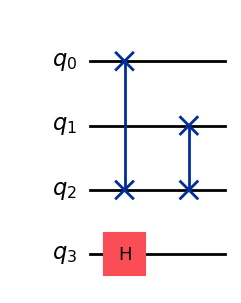

In [3]:
n = 4 #number of qubits the gate acts on

clifford_circuit = QuantumCircuit(n)
clifford_circuit.swap(0,2)
clifford_circuit.swap(1,2)
clifford_circuit.h(3)

clifford_circuit.draw(output='mpl')

First we must determine $$\mathcal{P}_{\mathcal{F}}= \{ P \in \mathcal{P}_n, \forall U \in \mathcal{U},\, UPU^\dagger = \pm P\}.$$

This is effeciently done by inspecting the symplectic matrix ,$F$, associated to the Clifford circuit.

In [4]:
symplectic_matrix =  get_symplectic( Clifford(clifford_circuit)) 
print(f'F = \n {symplectic_matrix}\n')

for i in range(n):
    print(f'X_{i} goes to {vec_to_pauli_str(symplectic_matrix[i])}')

for i in range(n):
    print(f'Z_{i} goes to {vec_to_pauli_str(symplectic_matrix[i+n])}')

F = 
 [[0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]]

X_0 goes to IXII
X_1 goes to IIXI
X_2 goes to XIII
X_3 goes to IIIZ
Z_0 goes to IZII
Z_1 goes to IIZI
Z_2 goes to ZIII
Z_3 goes to IIIX


The first $n$ rows are the binary vectors of the Pauli gate $C X_i C^\dagger $ and the second $n$ rows are the binary vectors of the pauli gates $C Z_i C^\dagger$.

For example we have $X_0 \rightarrow X_1 \rightarrow X_2$ or $Z_0 \rightarrow Z_1 \rightarrow Z_2$ or $X_4 \leftrightarrow Z_4$.

For a general Pauli $P_x$, we have $CPC^\dagger = \pm P_y$, where $y=Fx$.


For $P_x \in \mathcal{P}_\mathcal{F}$, we must have $x=Fx$, or $x(F\oplus I) =0$. We can compute a basis for $\mathcal{P}_{\mathcal{F}}$ by finding the left do this by computing the left kernel of $F \oplus I$.



In [5]:
M = (symplectic_matrix + np.eye(2*n))%2

P_f = kernel(M.T).toarray()
print(f'P_f ={[vec_to_pauli_str(x) for x in P_f]}')

P_f =['XXXI', 'ZZZI', 'IIIY']


Here $\mathcal{P}_{\mathcal{F}} = \langle X_0X_1X_2, Z_0Z_1Z_2, Y_3 \rangle$.

We know that any blind implementation of $\mathcal{F}$ takes at least 
\begin{align*}
N &= 2n-\dim(\mathcal{P}_{\mathcal{F}})\\
&= 2\times 4 - 3\\
&=5
\end{align*}
qubits of commuincation from Bob to Alice.

Since we are only interested in implementing $U \in \mathcal{F}$ up to a pauli gate, we can instead choose to blindly implement $P'U$ such that $$\forall P_x \in \mathcal{P}_\mathcal{F}\, (P'U) P_x (P'U)^\dagger  = + P_x.$$

We can construct such a $P'$ by first determining the phases of $UP_x U^\dagger$ and choosing $P'$ accordingly.

In [6]:
signs = []

for p in P_f:
    p_string = vec_to_pauli_str(p)
    p = make_qiskit_pauli(p_string)
    
    new_p=p.evolve(clifford_circuit, frame ='h')
    new_p_string, sign = label_from_qiskit_pauli(new_p)

    print(f'{p_string} goes to {sign + new_p_string}')

    if sign == '-':
        signs.append(1)
    else:
        signs.append(0)


XXXI goes to +XXXI
ZZZI goes to +ZZZI
IIIY goes to -IIIY


Here only $Y_3$ acquires a phase, choosing $P' = X_4$ is sufficient.

In general we can let $\{P_i\}$ be a basis for $\mathcal{P}_{\mathcal{F}}$, and define $v_i$ such that $U P_i U^\dagger = (-1)^{v_i} P_i$.

We can construct a new set of paulis $P'_i$ satisfying $P'_j P_i P'_j = (-1)^{\delta_{i,j}} P_i$. We would then have $P' = \prod_{i} P'^{v_i}_i$.

In [7]:
def get_circuit_factor(P_f, signs,n ):
    #Gram schmidt style procedure to construct paulis P'_i such that 
    r = len(P_f)
    M = np.eye(2*n)
    for i in range(r):
        for j in range(i,2*n):
            if symplectic_product(M[j], P_f[i])==1:
                break
        M[[i,j]] = M[[j,i]]
        for j in range(2*n):
            if j != i:
                if symplectic_product(M[j], P_f[i])==1:
                    M[j] = (M[j]+M[i])%2
    output = np.zeros((1,2*n))
    for i in range(r):
        if signs[i]==1:
            output =  (output + M[i])%2
    return output[0]

pauli_factor  = get_circuit_factor(P_f, signs, n)

print(f'P\' = {vec_to_pauli_str(pauli_factor)}')

P' = IIIX


The blind gate we instead want to implement is.

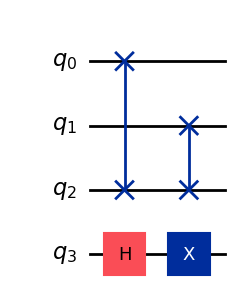

In [8]:
initial_pauli_gate = QuantumCircuit(n)

for i in range(n):
    x,z = pauli_factor[i], pauli_factor[i+n]
    if (x,z)==(1,0):
        initial_pauli_gate.x(i)
    elif (x,z) ==(0,1):
        initial_pauli_gate.z(i)
    elif (x,z) ==(1,1):
        initial_pauli_gate.y(i)

new_clifford_circuit = clifford_circuit.compose(initial_pauli_gate)
new_clifford_circuit.draw(output='mpl')

We know that $P'U$ has support on $\mathcal{B}$, where $\mathcal{B}$ is the set of Paulis that fully commute with $\mathcal{P}_\mathcal{F}$.
 
Since $\mathcal{B} = Ker(\mathcal{\mathcal{P}_{\mathcal{F}}} \Omega)$, we have $\dim(\mathcal{B})= 2n-r$ where $r = \dim(\mathcal{P}_\mathcal{F})$

In [9]:
Omega = symplectic_form_matrix(n)
B = kernel(P_f @ Omega).toarray()
N = len(B)

print(f'B={[vec_to_pauli_str(x) for x in B]}')

B=['IXXI', 'XXII', 'ZZII', 'ZIZI', 'IIIY']


Now that we have a basis for $\mathcal{B}$, we can construct the blind gate protocol.

Circuit implemented by Bob:


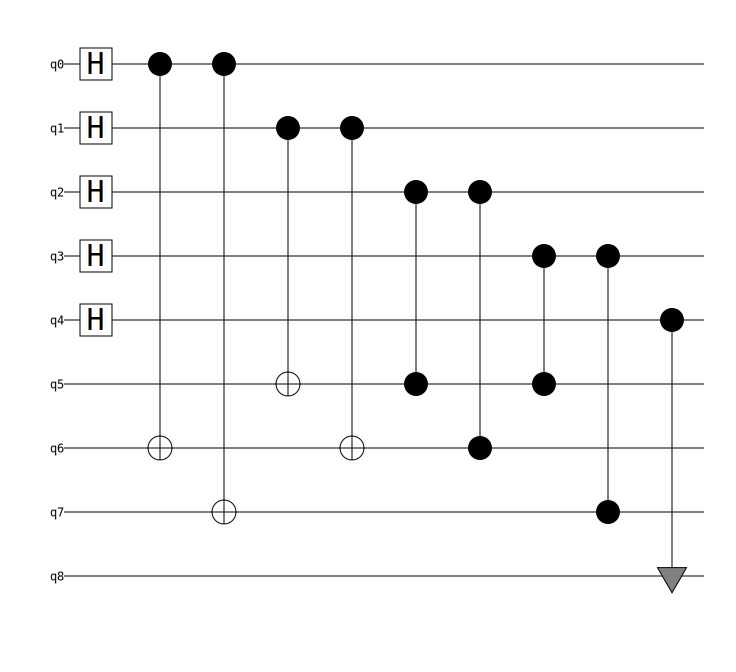

In [10]:
def make_circuit_protocol_entangled(B):
    N= len(B)
    n = len(B[0])//2
    protocol = Circuit()
    for i in range(N):
        protocol.append('H', i)
    for i in range(N):
        for j in range(n):
            x,z = B[i][j], B[i][j+n]
            if (x,z) == (1,0):
                protocol.append('CX', (i,N+j))
            if (x,z) == (0,1):
                protocol.append('CZ', (i,N+j))
            if (x,z) == (1,1):
                protocol.append('CY', (i,N+j))

    return protocol

print('Circuit implemented by Bob:')
protocol_circuit = make_circuit_protocol_entangled(B)
protocol_circuit.diagram('timeline-svg')

The first five qubits are initialised to $\ket{0}$, and bob places his state $\ket{\psi}$ in the register on the bottom four wires.

For Alice to blindly implement the gate $U\in \mathcal{F}$, she must measure in the $\ket{\phi^*_{B_z U}}$ basis.

The state is defined as $\ket{\phi^*_{B_zU}} = \sum_x \gamma^*_x \ket{x}$, where $\sum_{x} \gamma_x B_x =  B_z U$.

There is a natural way to measure in this basis when $U$ is Clifford. We can define a Clifford gate, $V_\textnormal{st}$, that satisfies $V_\textnormal{st} B_i V_\textnormal{st}^\dagger = X_i Z_{c(i)}$, for some binary strings $c(i)$ that preserve commutation relation.

We then have:
\begin{align*}
&V_{\textnormal{st}} U V_{\textnormal{st}}^\dagger \ket{0\dots 0}\\
&= V_{\textnormal{st}} \left( \sum_x \gamma_x B_x \right) V_{\textnormal{st}}^\dagger \ket{0\dots 0}\\
&=\sum_x \gamma_x x_x Z_{c(x)} \ket{0\dots 0}\\
&= \sum_x \gamma_x \ket{x}\\
&= \ket{\phi_{U}}
\end{align*}


We must therefore have $\ket{\phi_{B_x U}}$ be a stabilizer state. The stabilizers can be obtained, by tracking the stabilizers $Z_i$ through the Clifford circuit $V_{\textnormal{st}} B_x U V_{\textnormal{st}}^\dagger $.
Moreover, these circuits only differ by a Pauli gate, they must all have the same stabilizers, but differ on signs. We then have $\ket{\phi^*_{B_x U}}$ shares the same stabilizers.

Next we will construct $V_{\textnormal{st}}$ and find the set of stabilizers that we must measure.

In [11]:


def get_v_st(B):

    def get_anti_C(C):
        N = len(C)
        n = len(C[0])//2
        A= np.eye(2*n, dtype = int)
        for i in range(N):
            for j in range(i,2*n):
                if symplectic_product(A[j], C[i]) ==1:
                    break
            A[[i,j]] = A[[j,i]]

            for k in range(2*n):
                if k!= i and symplectic_product(A[k], C[i])==1:
                    A[k] = (A[k]+ A[i])%2
        return A
        

    #first we define vectors c_i satisfying b_i Omega b_j = c_i omega c_j, and extend to full bases. The resulitng map B^-1 C would map b_i to c_i
    N = len(B)
    n = len(B[0])//2
    size = max(N, n)

    if N>=n:
        B = np.array([pauli_str_to_vec(vec_to_pauli_str( b)+ 'I'*(N-n) ) for b in B])
    
    C = np.array([[1 if i==j else 0 for j in range(size)] +[symplectic_product(B[i], B[j]) if j<i else 0 for j in range(size)] for i in range(N)])


    current_rank = rank(B)
    for i in range(2*size):
        B_temp= list(B.copy())
        B_temp.append(np.array([1 if i==j else 0 for j in range(2*size)]))
        B_temp = np.array(B_temp)
        if rank(B_temp)> current_rank:
            B = B_temp
            current_rank = rank(B)

    for i in range(N, 2*size):
        #get necesarry commutaiton relations from BaseException
        commutation_relations = []
        for j in range(i):
            commutation_relations.append(symplectic_product(B[i],B[j]))
        anti_C =  get_anti_C(C)
        new_row = np.array([0 for _ in range(2*size)], dtype=int)
        for a, sign in enumerate(commutation_relations):
            if sign ==1:
                new_row = (new_row + anti_C[a])%2

        C = list(C)
        C.append(new_row)
        C = np.array(C)

        k=i+1
        while rank(C) < len(C):
            C[i] = (C[i]+ anti_C[k])%2
            k+=1

    return inverse(B)@C%2

V_st = get_v_st(B)

V_cliff = Clifford(V_st)
V_circ = V_cliff.to_circuit()

V_circ_dagger  = V_circ.inverse()

temp_U = clifford_circuit.copy()
temp_U.add_register(QuantumRegister(max(N-n, 0))) # if N>n, we must 


stab_circuit = V_circ_dagger
stab_circuit = stab_circuit.compose(temp_U)
stab_circuit = stab_circuit.compose(V_circ)


measurement_basis = []

for i in range(N):

    Z_i = make_qiskit_pauli('I'*i + 'Z' + 'I'*(max(n,N)-i-1))
    Z_i_new = Z_i.evolve(stab_circuit, frame='h')


    stab_in, sign_in =  label_from_qiskit_pauli(Z_i)
    stab_out, sign_out = label_from_qiskit_pauli(Z_i_new)

    print(f'{stab_in } is mapped to {sign_out + stab_out}')
    measurement_basis.append(pauli_str_to_vec(stab_out))
    
measurement_basis = np.array(measurement_basis)



ZIIII is mapped to -ZZXXI
IZIII is mapped to -ZIIXI
IIZII is mapped to +IXZII
IIIZI is mapped to +XIIZI
IIIIZ is mapped to +IIIIY


We can now implement the protocol. As we are simulating the circuit with Stim, Bob's choice of state must be a stabilizer state.

To make the action of the gate clear, Bob will choose the initial state $\ket{\psi} = \ket{+} \ket{+_y} \ket{0} \ket{0}$. If $U$ is applied, the resulting state will be $U\ket{\psi} =  \ket{0} \ket{+} \ket{+_y} \ket{+}$. The first three qubits are permuted and $H$ is applied to the final qubit.

In [12]:
prepare = Circuit()
prepare.append('H', N)
prepare.append('H', N+1)
prepare.append('S', N+1)
prepare.append('I', N+2)
prepare.append('I', N+3)


print('Bob initialises his state')

prepare.diagram()

Bob initialises his state


q0: -----

q1: -----

q2: -----

q3: -----

q4: -----

q5: -H---

q6: -H-S-

q7: ---I-

q8: ---I-

First we will simulate the scenario where Alice chooses to implement $I$. Here Alice will measure her qubits in the $Z$ basis.

In [13]:
total_circ = Circuit()
total_circ += prepare
total_circ += make_circuit_protocol_entangled(B)

sim = TableauSimulator()
sim.do(total_circ)

Z_basis = [PauliString('I'*i + 'Z' + 'I'*(N-i-1) + 'I'*n) for i in range(N)] #measuring in Z basis for identity

measurement_results= []
for P in Z_basis:
    result = sim.measure_observable(P)
    measurement_results.append(result)
print(f'measurement_results:\t{measurement_results}')
print('Final state')
for stab in sim.canonical_stabilizers():
    print(stab)

measurement_results:	[True, False, True, False, True]
Final state
-Z________
+_Z_______
-__Z______
+___Z_____
-____Z____
-_____X___
+______Y__
-_______Z_
-________Z


Only the signs of the stabilizers have changed, the state is unchanged up to Pauli gate. We now simulate the scenario where Alice measures in the $\ket{\phi^*_{B_x C}}$ basis.

In [14]:
total_circ = Circuit()
total_circ += prepare
total_circ += make_circuit_protocol_entangled(B)


sim = TableauSimulator()
sim.do(total_circ)


phi_U_basis = [PauliString( vec_to_pauli_str(p) + 'I'*n) for p in measurement_basis ] #measuring in |phi_{C}> basis for C

measurement_results= []
for P in phi_U_basis:
    result = sim.measure_observable(P)
    measurement_results.append(result)
print(f'measurement_results:\t{measurement_results}')
print('Final state')
for stab in sim.canonical_stabilizers():
    print(stab)

measurement_results:	[True, False, False, True, True]
Final state
-X__Z_____
+Z__X_____
+_XZ______
-_ZX______
-____Y____
+_____Z___
+______X__
+_______Y_
-________X


Up to a Pauli gate, the resulting state in Bob's possesion is $\ket{0} \ket{+} \ket{+_y} \ket{+}$ as desired!

We now show how Alice's quantum capabilites can be simplified even further. By performing row reductions on the stabilizers Alice measures, we can learn how to adjust the protcol such that Alice either measures in the $Z$ basis to implement the identity gate and the $X$ basis to implement $C$.

In [15]:
stab_clean,_ ,_ ,_ = reduced_row_echelon( measurement_basis )

print(f'New measurement stabilzer basis:')
for P in stab_clean:
    print(vec_to_pauli_str(P))


New measurement stabilzer basis:
XIIZI
IXZII
IZXII
ZIIXI
IIIIY


This reduced basis tells us how to adjust the circuit. $Z$ terms on the off diaganol correspond to an additional $\text{c}Z$ gate between the qubits. $Y$ terms along the diaganol, correspond to an additional $S$ gate. 

Optimal circuit with separable measurements:


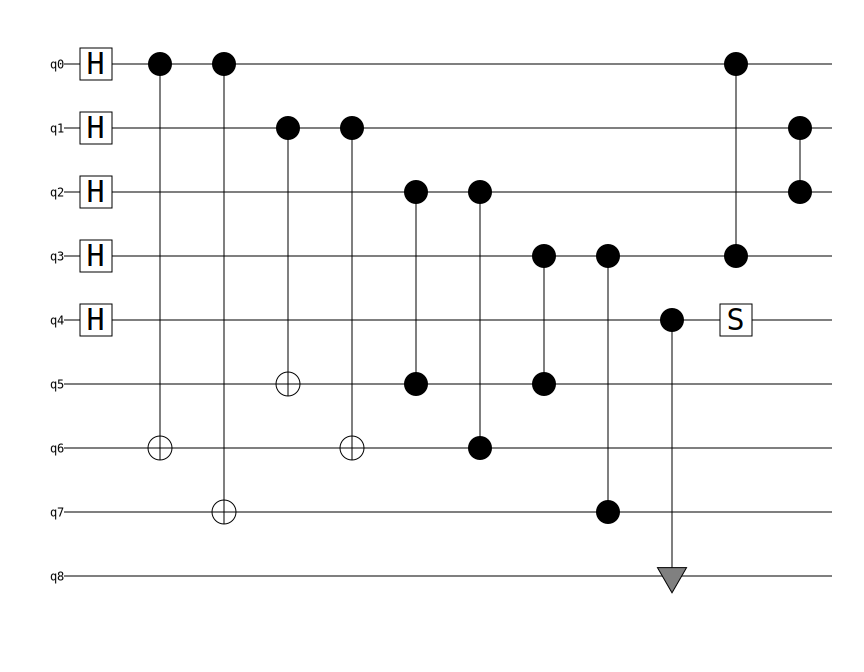

In [16]:
def make_circuit_protocol_separable(B, stab_clean):
    N= len(B)
    n = len(B[0])//2
    protocol = Circuit()
    for i in range(N):
        protocol.append('H', i)
    for i in range(N):
        for j in range(n):
            x,z = B[i][j], B[i][j+n]
            if (x,z) == (1,0):
                protocol.append('CX', (i,N+j))
            if (x,z) == (0,1):
                protocol.append('CZ', (i,N+j))
            if (x,z) == (1,1):
                protocol.append('CY', (i,N+j))
    for i in range(N):
        if stab_clean[i][i+N] == 1:
            protocol.append('S', i)
    for i in range(N):
        for j in range(i+1,N):
            if stab_clean[i][N+ j]==1:
                protocol.append('CZ', (i,j))
    return protocol

print('Optimal circuit with separable measurements:')

separable_circ = make_circuit_protocol_separable(B, stab_clean)
separable_circ.diagram('timeline-svg')

Again, lets simulate the scenario where alice chooses to implement the identity. Here she will measure her qubits in the $Z$ basis. 

In [17]:
total_circ = Circuit()
total_circ += prepare
total_circ += make_circuit_protocol_separable(B, stab_clean)

total_circ.diagram()

sim = TableauSimulator()
sim.do(total_circ)

measurement_basis = [PauliString( 'I'*i +'Z'+ 'I'*(N-n-1)) for i in range(N) ] #measuring in Z basis for identity

measurement_results= []
for P in measurement_basis:
    result = sim.measure_observable(P)
    measurement_results.append(result)

    
print(f'measurement_results:\t{measurement_results}')
print('Final state')
for stab in sim.canonical_stabilizers():
    print(stab)

measurement_results:	[True, True, False, False, False]
Final state
-Z________
-_Z_______
+__Z______
+___Z_____
+____Z____
+_____X___
+______Y__
-_______Z_
+________Z


As expected, the state is unchanged up to signs of stabilizers.
 
Let's now measure in the $X$ basis.

In [18]:
total_circ = Circuit()
total_circ += prepare
total_circ += make_circuit_protocol_separable(B, stab_clean)

sim = TableauSimulator()
sim.do(total_circ)

measurement_basis = [PauliString( 'I'*i +'X'+ 'I'*(N-n-1)) for i in range(N) ] #measuring in X basis for desired gate

measurement_results= []
for P in measurement_basis:
    result = sim.measure_observable(P)
    measurement_results.append(result)
print(f'measurement_results:\t{measurement_results}')
print('Final state')
for stab in sim.canonical_stabilizers():
    print(stab)

measurement_results:	[False, False, False, True, True]
Final state
+X________
+_X_______
+__X______
-___X_____
-____X____
-_____Z___
+______X__
-_______Y_
+________X


As desired, $\ket{\psi}$ is acted on by $C$.

If you would like to experiment with different optimal protocols for different Clifford gates. Below is the compact version of this process that accepts any qiskit circuit comprising of Clifford gates, and outputs an optimal protocol, both in the non-separable stabilizer setting, and in the separable.

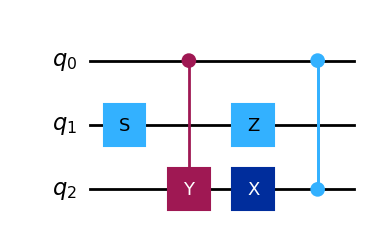

In [19]:
#Define qiskit Clifford circuit here:
num_qubits = 3
num_gates = 5
U = random_clifford_circuit(num_qubits , num_gates )

U.draw(output='mpl')

Basis to measure in for U:
YIX
IYI
XIZ
Number of qubits of communication:	3
Optimal circuit:


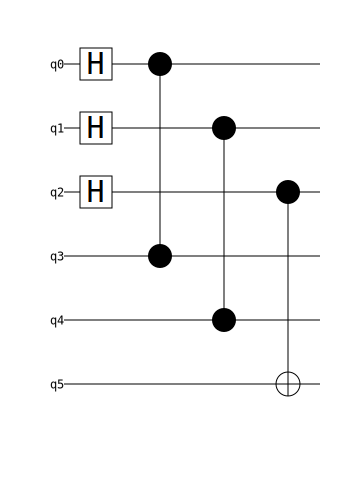

In [20]:

def nonseparable_protocol(U):
    #returns Stim circuit, and measurement basis for F ={I,U}

    n = U.num_qubits
    symplectic_matrix =  get_symplectic( Clifford(U)) 
    M = (symplectic_matrix + np.eye(2*n))%2
    P_f = kernel(M.T).toarray()

    Omega = symplectic_form_matrix(n)
    B = kernel(P_f @ Omega).toarray()
    N = len(B)

    optimal_circuit = make_circuit_protocol_entangled(B)
    
    V_st = get_v_st(B)

    Omega = symplectic_form_matrix(3)

    V_cliff = Clifford(V_st)
    V_circ = V_cliff.to_circuit()

    V_circ_dagger  = V_circ.inverse()

    temp_U = U.copy()

    if N >n:
        temp_U.add_register(QuantumRegister(N-n)) # if N>n, we must 

    stab_circuit = V_circ_dagger
    stab_circuit = stab_circuit.compose(temp_U)
    stab_circuit = stab_circuit.compose(V_circ)

    measurement_basis = []

    for i in range(N):

        Z_i = make_qiskit_pauli('I'*i + 'Z' + 'I'*(max(n,N)-i-1))
        Z_i_new = Z_i.evolve(stab_circuit, frame='h')

        stab_out, sign_out = label_from_qiskit_pauli(Z_i_new)
        measurement_basis.append(pauli_str_to_vec(stab_out))
        
    measurement_basis = np.array(measurement_basis)

    measurement_basis =[ vec_to_pauli_str(p)[:N] for p in measurement_basis]

    return optimal_circuit, measurement_basis

protocol, basis = nonseparable_protocol(U)

print('Basis to measure in for U:')
for P in basis:
    print(P)

print(f'Number of qubits of communication:\t{protocol.num_qubits - U.num_qubits}\nOptimal circuit:')

protocol.diagram('timeline-svg')





Optimal circuit:


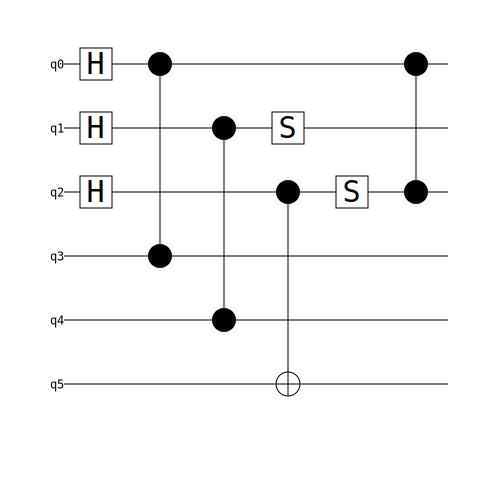

In [21]:
def separable_protocol(U):
    #returns Stim circuit, for F ={I,U}

    n = U.num_qubits
    symplectic_matrix =  get_symplectic( Clifford(U)) 
    M = (symplectic_matrix + np.eye(2*n))%2
    P_f = kernel(M.T).toarray()

    Omega = symplectic_form_matrix(n)
    B = kernel(P_f @ Omega).toarray()
    N = len(B)
    
    V_st = get_v_st(B)


    V_cliff = Clifford(V_st)
    V_circ = V_cliff.to_circuit()

    V_circ_dagger  = V_circ.inverse()

    temp_U = U.copy()

    if N >n:
        temp_U.add_register(QuantumRegister(N-n)) # if N>n, we must 

    stab_circuit = V_circ_dagger
    stab_circuit = stab_circuit.compose(temp_U)
    stab_circuit = stab_circuit.compose(V_circ)

    measurement_basis = []

    for i in range(N):

        Z_i = make_qiskit_pauli('I'*i + 'Z' + 'I'*(max(n,N)-i-1))
        Z_i_new = Z_i.evolve(stab_circuit, frame='h')

        stab_out, sign_out = label_from_qiskit_pauli(Z_i_new)
        print()
        measurement_basis.append(pauli_str_to_vec(stab_out[:N]))
        
    measurement_basis = np.array(measurement_basis)

    stab_clean,_ ,_ ,_ = reduced_row_echelon( measurement_basis )

    circuit = make_circuit_protocol_separable(B, stab_clean)
    return circuit

protocol = separable_protocol(U)

print('Optimal circuit:')
protocol.diagram('timeline-svg')


array([0., 0., 0., 1., 0., 0., 0., 0.])